# PHP 2530: Bayesian Statistical Methods Homework III

In [1]:
import numpy as np #useful math functions and everything else
import pandas as pd #makes dataframes which make problems easier
import matplotlib.pyplot as plt #for plotting our histograms and contours
import matplotlib.gridspec as gridspec #helps with plotting odd number of plots

#lets us use probability distributions like t, beta, gamma,etc.
from scipy.stats import norm, gamma, beta, chi2, binom, nbinom
from scipy.stats import spearmanr #for our test statistics
from statsmodels import api as sm #for our test statistics
from scipy.special import gammaln,betaln, boxcox, inv_boxcox # useful
from numpy.random import rand #Uniform(0,1). just makes writing more succinc

C:\Users\nicka\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Helpful function to calculate statistics
def param_stats(X,p,names,sig):
    '''
    PARAMETERS:
        X - data matrix
        p - the quantiles you wish to calculate
        names - names you want to give the parameters
        sig - number of digits to report
    Return:
        stats - a datframe detailing statistics about the parameters
    '''
    import pandas #declare this here in the case that we forget to apriori
    #we always specify the mean and standard deviation
    stats  = {
        'Mean': X.mean(axis=0),
        'Standard Deviation': X.std(axis=0,ddof=1)
                   } 
    #add quantile columns
    quant_names = [str(100*x) +'%' for x in p]
    for x in p: stats[ str(100*x) +'%'] = np.quantile(X,x,axis=0)
    
    return np.round(pd.DataFrame(stats,index = names),sig)

### Problem 1: (BDA 3rd Ed., Exercise 5.2)

> (a) Reproduce the computations in Section 5.5 for the educational testing example. Use
the posterior simulations to estimate (i) for each school j, the probability that its
coaching program is the best of the eight; and (ii) for each pair of schools, j and k,
the probability that the coaching program in school j is better than that in school k.

In [2]:
### PART A
school_df  = {
       'y': np.array([28,8,-3,7,-1,1,18,12]),
       'sd': np.array([15,10,16,11,9,11,10,18])
                   } 
school_df = pd.DataFrame(school_df)
#Number of iterations
N = 1000
#range of tau as described on page 121
tau = np.linspace(start = 0.0001, stop = 40, num = N)
#best guess of mu
mu = np.linspace(start = -30, stop = 30, num = N)

#prior for (mu,tau)
school_prior = lambda x,y: 1
#posterior density for (mu,tau)|y (bottom of page 116)
def school_post(data,sd,a,b,prior):
    '''
    PARAMETERS:
    ----------
        data - estimated means
        sd - accompanying standard deviations
        a - gridspace for mu
        b - grid space for tau
        prior - prior for hyperparameters
        
    Returns:
    -------
    logpost: natural logarithm of the unnormalized posterior distribution
    '''
    
    logprior = np.log(prior(a,b))

    def loglik(a,b,data,sd):
        return -((data - a)**2 / (2*(b**2 + sd**2))) - 0.5*np.log(b**2 + sd**2)    
    
    
    logpost = logprior + sum(loglik(a,b,data[j],sd[j]) for j in range(len(data)) )
    return logpost

#posterior distribution
school = school_post(data=school_df["y"].to_numpy(),
                     sd=school_df["sd"].to_numpy(),
                     a=mu[:,None],
                     b=tau[:,None,None],
                     prior = school_prior)

school = np.sum(school,axis=2)
#subtract to avoid overflow
school = np.exp( school - school.max()) 
#normalize the posterior
school = school / school.sum( )

#np.repeat repeats the vector; np.tile repeats the entries
mu_grid = np.repeat(mu,len(tau))
tau_grid = np.tile(tau,len(mu))

samples =  np.random.choice(school.size, size=N, p = school.ravel(order="F"))

#add some random jitter so the variables are continous random variables

#step sizes for our grids
d_mu = np.diff(mu)[0]/2
d_tau = np.diff(tau)[0]/2

mu_y = mu_grid[samples] -d_mu + d_mu*rand(N)
tau_y = tau_grid[samples] -d_tau + d_tau*rand(N)

 ### p($\tau$ | y) Plot

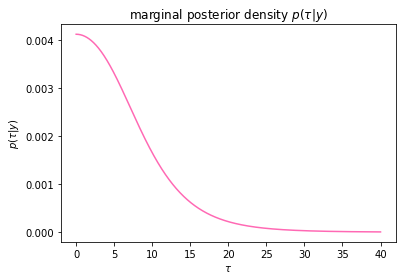

In [3]:
##### REPRODUCING CALCULATIONS IN SECTION 5.5 (FIGURES 5.5-5.7)

#Letters for school labels
LETTERS = ["A","B","C","D","E","F","G","H"]

# Tau posterior Plot

plt.plot(tau,school.sum(axis=1),color="hotpink")
plt.title(r'marginal posterior density $p(\tau|y)$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$p(\tau | y)$')
plt.show()

### E($\theta_j$ | $\tau$, y) Plot

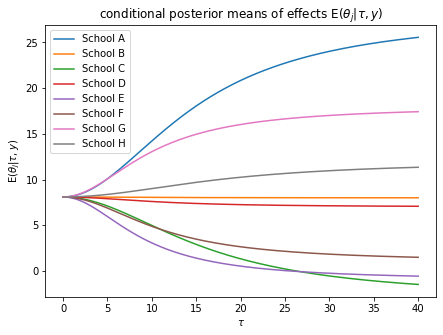

In [4]:
# E(theta_j | tau,y) Plot

def expected_tau(x,data,sd):
    '''
    PARAMETERS:
    ----------
        x - grid for tau
        data - estimated means
        sd - accompanying standard deviations
    
    Returns:
    -------
    E(theta_j | tau, y) for each school
    '''
    mu_hat = np.sum(data/(sd**2 + x**2)) / np.sum(1/(sd**2+x**2))
    V_tau = 1 / ( (1/x)**2 +  (1/sd)**2)
    return  ((mu_hat/ x**2) + (data/ sd**2))*(V_tau)

school_mean = expected_tau(x = tau[:,None],
                    data = school_df["y"].to_numpy(),
                    sd = school_df["sd"].to_numpy() )

plt.figure(figsize = (7,5))
[plt.plot(tau,school_mean[:,j]) for j in range(school_df.shape[0])]
plt.title(r'conditional posterior means of effects '
                  r'$\operatorname{E}(\theta_j|\tau,y)$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\operatorname{E}(\theta_j | \tau, y)$')
plt.legend(['School '+ LETTERS[j] for j in range(school_df.shape[0])])
plt.show()

### sd($\theta_j$ | $\tau$, y) Plot

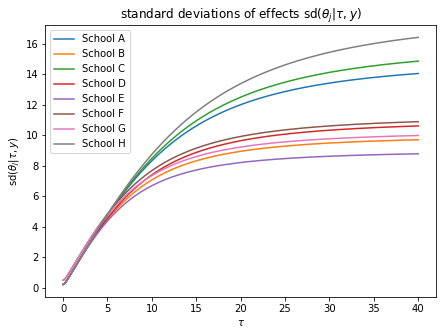

In [5]:
# sd(theta_j | tau,y) Plot

def sd_tau(x,data,sd):
    '''
    PARAMETERS:
    ----------
        x - grid for tau
        data - estimated means
        sd - accompanying standard deviations
    
    Returns:
    -------
    sd(theta_j | tau,y) for each school
    '''
    mu_hat = 1 / np.sum(1/(sd**2+x**2))
    V = 1 / ( (1/x)**2 +  (1/sd)**2)
    V_tau = (1/x)**2 / ( (1/x)**2 +  (1/sd)**2)
    return  np.sqrt(V + mu_hat*V_tau**2)

school_sd = sd_tau(x = tau[:,None],
                    data = school_df["y"].to_numpy(),
                    sd = school_df["sd"].to_numpy() )

#add little jitter so these are visible
school_sd[:,6] = school_sd[:,6] + 75*np.diff(school_sd[:,6])[0]
school_sd[:,5] = school_sd[:,5] + 75*np.diff(school_sd[:,5])[0]

plt.figure(figsize = (7,5))
[plt.plot(tau,school_sd[:,j]) for j in range(school_df.shape[0])]
plt.title(r'standard deviations of effects '
                  r'$\operatorname{sd}(\theta_j|\tau,y)$')
plt.xlabel(r'$\tau$')
plt.ylabel( r'$\operatorname{sd}(\theta_j | \tau, y)$')
plt.legend(['School '+ LETTERS[j] for j in range(school_df.shape[0])])
plt.show()

In [6]:
#new updates mu and tau based on posterior draws  
def theta_post(x,y,data,sd):
    '''
    PARAMETERS:
        x - posterior draws for mu
        y - posterior draws for tau
        data - estimated means
        sd - accompanying standard deviations
    
    Returns:
    -------
    Posterior draws theta_j | tau, mu, y for each school
    '''
    V = np.sqrt(1 / ( (1/y)**2 + (1/sd)**2 ) )
    theta_hat = ((x/ y**2) + (data/ sd**2))*(V**2)
    return norm.rvs(loc = theta_hat, scale = V)

#use updates to now make informed draws of theta_j
thetas = theta_post(x = mu_y[:,None], 
                    y = tau_y[:,None],
                    data = school_df["y"].to_numpy(),
                    sd = school_df["sd"].to_numpy() )

Probability of School $\theta_j$ being better than school $\theta_k$

In [9]:
#nicer way to write our probability matrix
Probs = np.array([np.mean(thetas[:,i] > thetas[:,j]) for 
                 i in range(school_df.shape[0]) for j in range(school_df.shape[0])])

#turns array into matrix and turns it into dataframe
Probs = pd.DataFrame(Probs.reshape(school_df.shape[0],school_df.shape[0]), 
                             index = LETTERS,
                             columns = LETTERS )
Probs

,A,B,C,D,E,F,G,H
A,0.000,0.656,0.687,0.652,0.744,0.698,0.548,0.628
B,0.344,0.000,0.583,0.530,0.631,0.596,0.377,0.480
C,0.313,0.417,0.000,0.431,0.541,0.498,0.319,0.419
D,0.348,0.470,0.569,0.000,0.609,0.577,0.376,0.474
E,0.256,0.369,0.459,0.391,0.000,0.454,0.279,0.392
F,0.302,0.404,0.502,0.423,0.546,0.000,0.313,0.433
G,0.452,0.623,0.681,0.624,0.721,0.687,0.000,0.591
H,0.372,0.520,0.581,0.526,0.608,0.567,0.409,0.000


Proabability of School $\theta_k$ being the best

In [7]:
#smoother way to write our for loop for the best probability calculation
Best = [np.mean(thetas[:,i] == thetas.max(axis=1)) for i in range(school_df.shape[0])]
Best = pd.DataFrame(Best, index = LETTERS)
Best.columns = ["Probability of Being Best School"]

Best

,Probability of Being Best School
A,0.267
B,0.096
C,0.071
D,0.105
E,0.061
F,0.077
G,0.201
H,0.122


> (b) Repeat (a), but for the simpler model with $\tau$ set to $\infty$ (that is, separate estimation
for the eight schools). In this case, the probabilities (ii) can be computed analytically.

Probability of School $\theta_j$ being better than school $\theta_k$

In [10]:
#PART B
theta_inf = norm.rvs(loc = school_df['y'].to_numpy(), 
                     scale = school_df['sd'].to_numpy(), 
                     size = (N,school_df.shape[0]))

#nicer way to write our probability matrix
Probs_inf = np.array([np.mean(theta_inf[:,i] > theta_inf[:,j]) for 
                 i in range(school_df.shape[0]) for j in range(school_df.shape[0])])

#turns array into matrix and turns it into dataframe
Probs_inf = pd.DataFrame(Probs_inf.reshape(school_df.shape[0],school_df.shape[0]), 
                             index = LETTERS,
                             columns = LETTERS )
Probs_inf

,A,B,C,D,E,F,G,H
A,0.000,0.850,0.916,0.850,0.946,0.924,0.699,0.761
B,0.150,0.000,0.712,0.509,0.765,0.680,0.248,0.434
C,0.084,0.288,0.000,0.282,0.445,0.431,0.136,0.287
D,0.150,0.491,0.718,0.000,0.741,0.669,0.250,0.447
E,0.054,0.235,0.555,0.259,0.000,0.440,0.069,0.269
F,0.076,0.320,0.569,0.331,0.560,0.000,0.129,0.312
G,0.301,0.752,0.864,0.750,0.931,0.871,0.000,0.638
H,0.239,0.566,0.713,0.553,0.731,0.688,0.362,0.000


Probability of School $\theta_k$ being the best.

In [11]:
#PART B
#nicer way to write our for loop and calculate probability of being best school
Best_inf = [np.mean(theta_inf[:,i] == theta_inf.max(axis=1)) 
            for i in range(school_df.shape[0])]

Best_inf = pd.DataFrame(Best_inf, index = LETTERS)
Best_inf.columns = ["Probability of Being Best School"]

Best_inf

,Probability of Being Best School
A,0.540
B,0.038
C,0.030
D,0.036
E,0.002
F,0.016
G,0.188
H,0.150


### Problem 4 (BDA 3rd Ed. Exercise 5.14)
Hierarchical Poisson model: consider the dataset in the previous problem, but suppose
only the total amount of traffic at each location is observed.

> (b) Compute the marginal posterior density of the hyperparameters and plot its contours. Simulate random draws from the posterior distribution of the hyperparameters and make a scatterplot of the simulation draws.

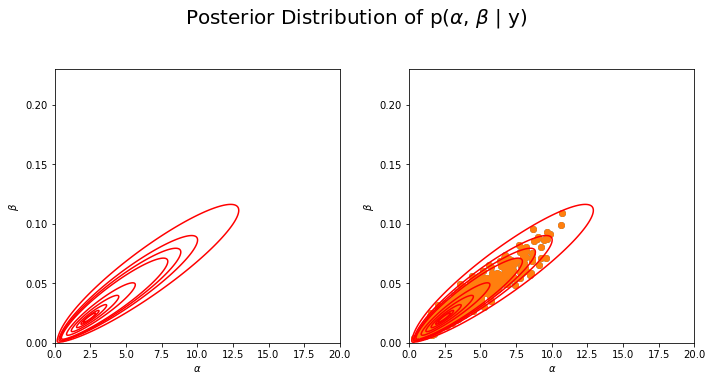

In [3]:
### PROBLEM 4 (BDA 3rd Ed. Exercise 5.14)

# number of vehicles on residential street with bike lane
#y-bikes for streets w/ bike lanes;v- vehicles for streets w/ bike lanes

res_df = {
       'bikes': np.array([16, 9, 10, 13,19, 20, 18, 17,35, 55]),
       'vehicles': np.array([58,90, 48, 57, 103, 57, 86,112, 273, 64])
                   } 

res_df = pd.DataFrame(res_df)
res_df['total'] = res_df['bikes'] + res_df['vehicles']

#Grid for sampling
R = 1000
alpha = np.linspace(start = 0.0001, stop = 17, num = R)
betas = np.linspace(start = 0.0001, stop = 0.6, num = R)

street_prior = lambda x,y : (x+y)**(-5/2)
#Posterior Function. It is of form seen in derivation
def vehicle_post(v,a,b,prior):
    '''
    PARAMETERS:
    ----------
    v - data on number of vehicles on residential street 
    a - alpha parameter
    b - beta parameter
    prior - prior on alpha, beta
    Returns:
    -------
    logpost : natural logarithm of unnormalized posterior density
    '''
    #prior distribution used for this problem
    logprior = np.log(prior(a,b))

    # for brevity, split the likelihood into a numerator term and denominator
    def loglik(a,b,v):
     l = gammaln(a+v) + a*np.log(b) - ( gammaln(a) + gammaln(v+1) 
                                                + (v+a)*np.log(1+b) )
     return l

    logpost = logprior + sum(loglik(a,b,v[j]) for j in range(len(v)) )
    return logpost

posty = vehicle_post(v=res_df['total'].to_numpy(), 
                     a = alpha[:,None], 
                     b= betas[:,None,None],
                     prior = street_prior)

posty = posty.sum(axis=2)
#subtract to avoid overflow
posty = np.exp( posty - posty.max()) 
#normalize the posterior
posty = posty / posty.sum( )

#np.repeat repeats the vector; np.tile repeats the entries
alpha_grid = np.repeat(alpha,len(betas))
beta_grid = np.tile(betas,len(alpha))

#posterior draw indices
samples = np.random.choice(posty.size, size=R, p = posty.ravel(order="F"))

#step sizes for random jitter
d_alpha = np.diff(alpha)[0]/2
d_beta = np.diff(betas)[0]/2

#add some random jitter so the variables are continous random variables
alpha_post = alpha_grid[samples] - d_alpha + d_alpha*rand(R)
beta_post = beta_grid[samples] - d_beta + d_beta*rand(R)

#plots contours and simulated points

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

ax = [ax1,ax2]

#contour levels for posterior

lev = [ 0.001, 0.01,.025,0.05,0.25,0.50,0.75,0.90,0.95]
cont = np.quantile(np.linspace(posty.min(),posty.max(),10000),lev)

for j in range(2):
    ax[j].contour(alpha, betas, posty,levels=cont,colors='red')
    ax2.scatter(alpha_post,beta_post,zorder=1)
    ax[j].set_ylim(0,0.23)
    ax[j].set_ylabel(r'$\beta$')
    ax[j].set_xlim(0,20)
    ax[j].set_xlabel(r'$\alpha$')
fig.suptitle(r'Posterior Distribution of p($\alpha$, $\beta$ | y)', y = 1.05,fontsize=20)
fig.tight_layout()

> (e) Draw samples from the joint posterior distribution of the parameters and hyperparameters, by analogy to the method used in the hierarchical binomial model

In [12]:
# Draw posterior values of the theta_j's

#this will hold ALL OF OUR samples
thetas = gamma.rvs(a = alpha_post[:,None] + res_df['total'].to_numpy(),
                   scale = 1/(beta_post[:,None] + 1),
                  size = (R,10))

#concatenate our hyperparameters and parameters together
param = np.hstack((alpha_post.reshape(R,1),beta_post.reshape(R,1),thetas))

param_names = np.concatenate([ ['\u03B1','\u03B2'],
                        ['\u03B8'+str(j) for j in range(1,res_df.shape[0]+1)]])

#The posterior distributions of each theta_j.
vehicle_stats  = {
        'Mean': param.mean(axis=0),
        'Standard Deviation': param.std(axis=0,ddof=1),
        '2.5%': np.percentile(param,2.5,axis=0),
        '25%': np.percentile(param,25.0,axis=0),
        '50%': np.percentile(param,50.0,axis=0),
        '75%': np.percentile(param,75.0,axis=0),
        '97.5%': np.percentile(param,97.5,axis=0)
                   } 

vehicle_stats = np.round(pd.DataFrame(vehicle_stats,index=param_names),3)
pd.set_option("display.max_columns", 7)
print(vehicle_stats)

        Mean  Standard Deviation     2.5%      25%      50%      75%    97.5%
α      3.794               1.842    1.150    2.433    3.464    4.847    8.246
β      0.034               0.017    0.011    0.021    0.031    0.043    0.074
θ1    75.516               8.780   58.566   69.784   75.156   81.053   93.761
θ2    98.890               9.397   81.864   92.525   98.486  104.909  119.330
θ3    59.563               7.852   44.574   54.008   59.433   64.683   75.962
θ4    71.243               8.140   55.701   65.589   71.250   76.825   87.402
θ5   121.967              10.670  102.135  114.715  121.897  128.622  142.892
θ6    77.809               8.570   61.846   72.023   77.481   83.490   96.192
θ7   103.862              10.124   85.823   96.995  103.155  110.491  125.532
θ8   128.919              11.127  108.423  121.238  128.454  136.620  150.904
θ9   301.131              17.349  268.718  288.731  301.314  312.865  334.768
θ10  118.564              11.023   97.978  111.008  118.649  125

### Problem 5: (BDA 3rd Ed., Exercise 6.2)
 Model checking: in Exercise 2.13, the counts of airline fatalities in 1976–1985 were fitted
to four different Poisson models.

> (a)  For each of the models, set up posterior predictive test quantities to check the following
assumptions: (1) independent Poisson distributions, (2) no trend over time.

To test (1) Independent Poisson Distributions, we use the 1st lag of the autocorrelations.
\begin{alignat*}{1}
acf(x)_k &= \frac{\sum^{n-k}_{t=1} y_t y_{t+k}}{\sum^{n}_{t=1}y_t}\\
\end{alignat*}

To test (2) No Trend over time we use spearman correlations

\begin{alignat*}{1}
r_s = corr(r_X,r_Y) = \frac{Cov(r_X,r_Y)}{sd(r_X)sd(r_Y)}\\
=\frac{\sum^{n-k}_{t=1} (r_{t,X} - \bar r_X)(r_{t,Y} - \bar r_Y)}{\sqrt{\sum^{n}_{t=1} (r_{t,X} - \bar r_X)^2} \sqrt{\sum^{n}_{t=1} (r_{t,Y} - \bar r_Y)^2}}\\
\end{alignat*}

(b) For each of the models, use simulations from the posterior predictive distributions to
measure the discrepancies. Display the discrepancies graphically and give p-values.

In [12]:
#Problem 5 (BDA 3rd. Ed. Exercise 6.2)
#number of fatal accidents between 1976-1985

### STORES OUR INFORMATION

df  = {
       'Accidents':np.array([24, 25, 31, 31, 22, 21, 26, 20, 16, 22]),
       'Deaths': np.array([734, 516, 754, 877, 814, 362, 764, 809, 223, 1066]),
       'Year': np.arange(1,11),
       'Death Rate': np.array([0.19, 0.12, 0.15, 0.16, 0.14,
                               0.06, 0.13, 0.13, 0.03, 0.15])
                   } 
df = pd.DataFrame(df)

#Adds new column of miles flown
df['Miles'] = df['Deaths']*1e8 / df['Death Rate']

#Model 1
#number of simulations for our posterior predictive check
N6 = 1000

#prior parameters
prior_shape = 0; prior_rate = 0

#size parameters for negative binomials

sizes =  np.array([df['Accidents'].sum(),df['Deaths'].sum()]) + prior_shape
    
#corresponding probability parameters
probs1 = np.repeat(df.shape[0]/(df.shape[0]+1+prior_rate),10)
probs2 = df['Miles'].sum()/(df['Miles'].sum()+np.asarray(df['Miles'])+prior_rate)
    
Model1_draws = nbinom.rvs(size=(N6,10),n = sizes[0], p= probs1)
Model2_draws = nbinom.rvs(size=(N6,10),n = sizes[0], p= probs2) 
Model3_draws = nbinom.rvs(size=(N6,10),n = sizes[1], p= probs1) 
Model4_draws = nbinom.rvs(size=(N6,10),n = sizes[1], p= probs2) 

(1) Independent Poisson Distributions 

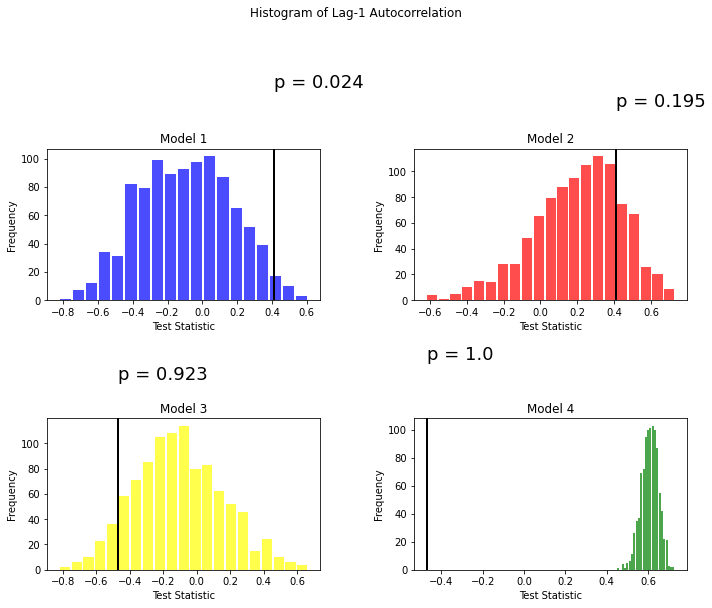

In [13]:
# (1) Independent Observations (Autocorrelations)

#Replications
Model1_Stat1 = np.array([sm.tsa.acf(Model1_draws[j,],fft=False)[1]
                    for j in range(N6)])
Model2_Stat1 = np.array([sm.tsa.acf(Model2_draws[j,],fft=False)[1]
                    for j in range(N6)])
Model3_Stat1 = np.array([sm.tsa.acf(Model3_draws[j,],fft=False)[1]
                    for j in range(N6)])
Model4_Stat1 = np.array([sm.tsa.acf(Model4_draws[j,],fft=False)[1]
                    for j in range(N6)])


#Observed Values
acc_obs_T1 = sm.tsa.acf(df['Accidents'],fft=False)[1]
death_obs_T1 = sm.tsa.acf(df['Deaths'],fft=False)[1]

Test1 = np.array([Model1_Stat1,Model2_Stat1,Model3_Stat1,Model4_Stat1])
Test1_obs = np.array([acc_obs_T1,acc_obs_T1,death_obs_T1,death_obs_T1])
Test1_pvalues = [(Test1[j,:] >= Test1_obs[j]).mean() for j in range(4)]

col = ["blue","red","yellow","green"]
model_number = ['Model 1','Model 2','Model 3','Model 4']
fig, [[ax1, ax2],[ax3, ax4]]  = plt.subplots(2, 2,figsize=(10,8))
ax = [ax1,ax2,ax3,ax4]

for j in range(4):
    plt.tight_layout()
    ax[j].hist(x = Test1[j,:],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].axvline(Test1_obs[j], color='black', linewidth=2)
    ax[j].text(Test1_obs[j], 150,'p = ' + str(Test1_pvalues[j]), fontsize = 18)
    ax[j].set_xlabel("Test Statistic")
    ax[j].set_ylabel('Frequency')
    ax[j].set_title(model_number[j])

fig.suptitle('Histogram of Lag-1 Autocorrelation', y = 1.05)
fig.tight_layout()

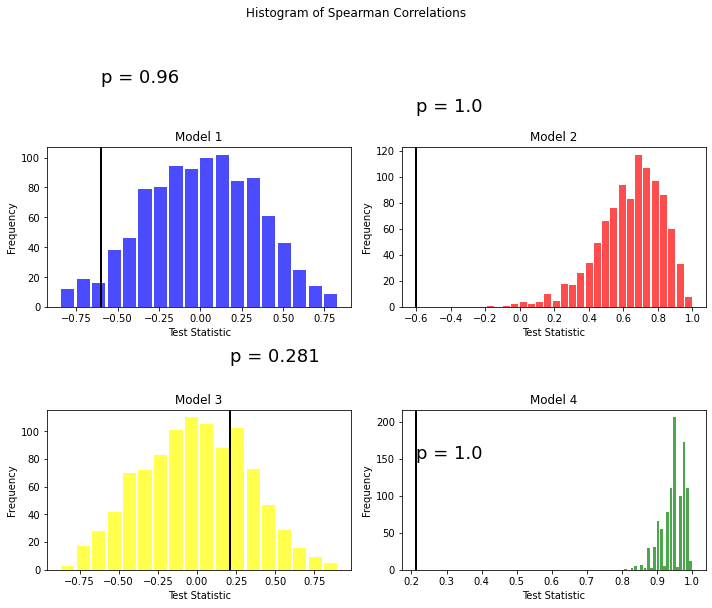

In [15]:
# (2) No Time Trend Over Time (Spearman Correlation)

Model1_Stat2 = np.array([spearmanr(Model1_draws[j,:],df['Year'])[0]
                    for j in range(N6)])
Model2_Stat2 = np.array([spearmanr(Model2_draws[j,:],df['Year'])[0]
                    for j in range(N6)])
Model3_Stat2 = np.array([spearmanr(Model3_draws[j,:],df['Year'])[0]
                    for j in range(N6)])
Model4_Stat2 = np.array([spearmanr(Model4_draws[j,:],df['Year'])[0]
                    for j in range(N6)])

#Observed Values
acc_obs_T2 = spearmanr(df['Accidents'],df['Year'])[0]
death_obs_T2 = spearmanr(df['Deaths'],df['Year'])[0]

Test2 = np.array([Model1_Stat2,Model2_Stat2,Model3_Stat2,Model4_Stat2])
Test2_obs = np.array([acc_obs_T2,acc_obs_T2,death_obs_T2,death_obs_T2])
Test2_pvalues = [(Test2[j,:] >= Test2_obs[j]).mean() for j in range(4)]

col = ["blue","red","yellow","green"]
model_number = ['Model 1','Model 2','Model 3','Model 4']
fig, [[ax1, ax2],[ax3, ax4]]  = plt.subplots(2, 2,figsize=(10,8))
ax = [ax1,ax2,ax3,ax4]

for j in range(4):
    plt.tight_layout()
    ax[j].hist(x = Test2[j,:],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].axvline(Test2_obs[j], color='black', linewidth=2)
    ax[j].text(Test2_obs[j], 150,'p = ' + str(Test2_pvalues[j]), fontsize = 18)
    ax[j].set_xlabel("Test Statistic")
    ax[j].set_ylabel('Frequency')
    ax[j].set_title(model_number[j])
fig.suptitle('Histogram of Spearman Correlations', y = 1.05)
fig.tight_layout()

###  Problem 6: (BDA 3rd Ed. Exercise 6.5)

Prior vs. posterior predictive checks (from Gelman, Meng, and Stern, 1996): consider 100 observations, $y_1,\dots,y_n$, modeled as independent samples from a $N(\theta,1)$ distribution with a diffuse prior distribution, say, $p(\theta)=\frac{1}{2A}$ for $\theta \in [-A,A]$ with some extremely large value of A, such as $10^5 $. We wish to check the model using, as a test statistic,
$T(y) = \max_{j} |y_j|$: is the maximum absolute observed value consistent with the normal
model? Consider a dataset in which $\bar y = 5.1$ and $T(y)=8.1$.


> (a)  What is the posterior predictive distribution for $y^{rep}$? Make a histogram for the
posterior predictive distribution of $T(y^{rep})$ and give the posterior predictive p-value for the observation $T(y)=8.1$.

Text(0.5, 1.0, 'Posterior Predictive $T(y^{rep})$ = $\\operatorname{max}_{j} |y_j|$')

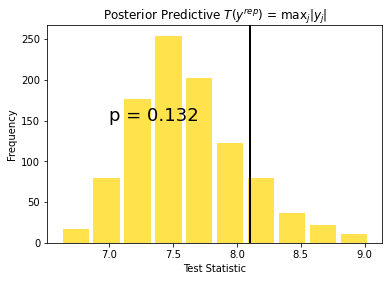

In [23]:
### PROBLEM 6 (BDA  3rd Ed., Exercise 6.5)

# PART A

def post_pred(y,N):
  '''
      PARAMETERS:
          y - mean of the data
          N - number of samples in the data
          
      Returns:
      -------
      test statistic : the absolute value of the maximum from 100 samples
  '''
  p = norm.rvs(size=N,loc = y,scale=np.sqrt(1+1/N))
  return abs(max(p)) 


sample_max = np.array([post_pred(y=5.1,N=100) for j in range(1000)])

plt.hist(x = sample_max,color='gold', alpha=0.7, rwidth=0.85)
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.axvline(8.1, color='black', linewidth=2)
plt.text(7, 150,'p = ' + str((sample_max >= 8.1).mean()), fontsize = 18)
plt.title(r'Posterior Predictive $T(y^{rep})$ = '
                  r'$\operatorname{max}_{j} |y_j|$')

> (b) The prior predictive distribution is $p(y^{rep}) = \int p(y^{rep}|\theta)p(\theta)d\theta.$ (Compare to equation
(6.1).) What is the prior predictive distribution for $y^{rep}$ in this example? Roughly
sketch the prior predictive distribution of $T(y^{rep})$ and give the approximate prior predictive p-value for the observation $T(y)=8.1$.


Text(0.5, 1.0, 'Prior Predictive $T(y^{rep})$ = $\\operatorname{max}_{j} |y_j|$')

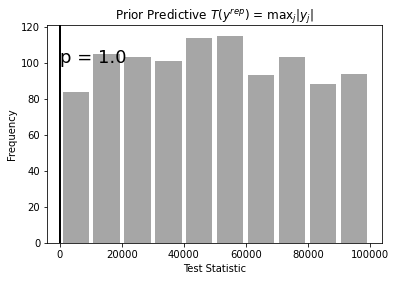

In [24]:
# PART B

def prior_pred(n,A):
  '''
  PARAMETERS:
    n - number of draws
    A - bounds of the uniform prior on theta (i.e. theta ~Unif(-A,A))
  
  Return:
  ------
   test statistic : the absolute value of the maximum from 100 samples
  '''
  theta = -A + A*rand(n)
  draws = norm.rvs(size = (n,100), loc = theta[:,None], scale = 1)
  reps = abs(draws.max(axis=1))
  return reps 

prior_max = prior_pred(n=1000,A=1e5)

plt.hist(x = prior_max,color='gray', alpha=0.7, rwidth=0.85)
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.axvline(8.1, color='black', linewidth=2)
plt.text(7, 100,'p = ' + str((prior_max >= 8.1).mean()), fontsize = 18)
plt.title(r'Prior Predictive $T(y^{rep})$ = '
                  r'$\operatorname{max}_{j} |y_j|$')

### Problem 7: (BDA 3rd Ed. Exercise 6.9)
Model checking: check the assumed model fitted to the rat tumor data in Section 5.3.
Define some test quantities that might be of scientific interest, and compare them to
their posterior predictive distributions.

> Now we define our test quantities of interest. More or less there are a couple pertinent features that we would like to be seen in the model. Firstly, we want to observe a similar proportion of tumors in our replications as was seen in the the observed data. This would tell us that our model is capable of producing experiments with reasonable tumor frequencies. Secondly, we wouldn't like for our model to over- or under-predict the number of tumors present in the rats. We therefore propose the maximum as test statistic. The maximum will tell us whether or not our model is overpredicting or underpredicting the extremes. We would like to do the same thing with the minimum but the data is extremely sparse; there are many 0's. One option would be to define the number of 0's present as a test statistic to get around this conundrum. Our three statistics will then be:

\begin{alignat*}{1}
T_1(y) &= \max_{j} \{y_1,y_2,\dots,y_J\} \\
T_2(y) &= \frac{1}{J} \sum^{J}_{j=1} \frac{y_j}{n_j}\\
T_3(y) &= \sum^{J}_{j=1} I_{\{ y_j=0 \}} \\
\end{alignat*}

In [13]:
### Problem 7 (BDA 3rd Ed., Exercise 6.9)
#Rat Tumor Example

rat_df  = {
       'rats':np.array([
           20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
           20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
           46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
           48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
           47, 24, 14
       ]),
       'tumors': np.array([
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
            1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
            5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
           10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
           15,  9,  4
       ])
                   } 
rat_df = pd.DataFrame(rat_df)

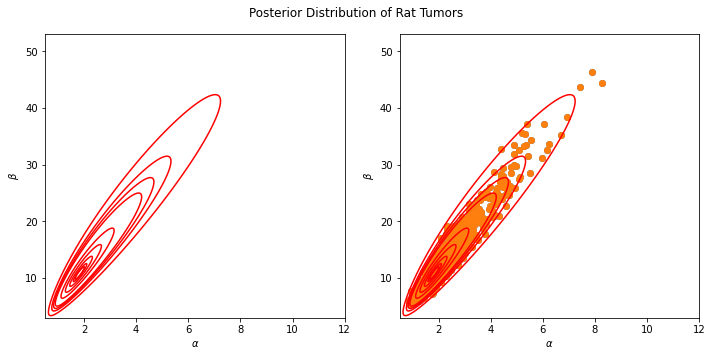

In [18]:
R2 = 1000

ralpha = np.linspace(start = 0.5, stop = 12, num = R2)
rbeta = np.linspace(start = 3, stop = 53, num = R2)

street_prior = lambda x,y : (x+y)**(-5/2)
#of form seen in derivation
def bicycle_post(y,n,a,b,prior):
    '''
    PARAMETERS:
    ----------
        y - data on bicyle proportions on residential street 
        n - number of vehicles seen in total
        a - alpha parameter
        b - beta parameter
        prior - prior for alpha, beta
    Returns:
    -------
        logpost: natural logarithm of unnormalized posterior density
    '''
    
    #prior distribution used for this problem
    logprior = np.log(prior(a,b))
    
    # for brevity, split the likelihood into a numerator term and denominator
    def loglik(a,b,n,y):
        return betaln(a+y,b+(n-y))-betaln(a,b) 
    logpost = logprior + sum(loglik(a,b,n[j],y[j]) for j in range(len(y)))    
    return logpost

rat_post = bicycle_post(y = np.asarray(rat_df['tumors']), 
                        n = np.asarray(rat_df['rats']), 
                        a = ralpha[:,None], 
                        b = rbeta[:,None,None],
                        prior = street_prior)
rat_post = np.sum(rat_post,axis=2)
#subtract to avoid overflow
rat_post = np.exp( rat_post - rat_post.max()) 
#normalize the posterior
rat_post = rat_post / rat_post.sum( )


#np.repeat repeats the vector; np.tile repeats the entries
ralpha_grid = np.repeat(ralpha,len(rbeta))
rbeta_grid = np.tile(rbeta,len(ralpha))

samples = np.random.choice(rat_post.size, size=R2, p = rat_post.ravel(order="F"))

#add some random jitter so the variables are continous random variables

d_ralpha = np.diff(ralpha)[0]/2
d_rbeta = np.diff(rbeta)[0]/2

ralpha_post = ralpha_grid[samples] -d_ralpha + (d_ralpha)*rand(R2)
rbeta_post = rbeta_grid[samples] -d_rbeta + (d_rbeta)*rand(R2)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5))

ax = [ax1,ax2]

#contour levels for posterior
lev = [0.001, 0.01,.025,0.05,0.25,0.50,0.75,0.90,0.95]
cont = np.quantile(np.linspace(rat_post.min(),rat_post.max(),100000),lev)

for j in range(2):
    ax[j].contour(ralpha, rbeta, rat_post,levels=cont, colors='red', zorder = 2)
    ax2.scatter(ralpha_post, rbeta_post, zorder = 1)
    ax[j].set_ylabel(r'$\beta$')
    ax[j].set_xlabel(r'$\alpha$')
fig.suptitle('Posterior Distribution of Rat Tumors')
fig.tight_layout()

theta_r  = beta.rvs(a = ralpha_post[:,None] + (rat_df['tumors']).to_numpy(),
                    b = rbeta_post[:,None] + (rat_df['rats']- rat_df['tumors']).to_numpy(), 
                    size = (R2,rat_df.shape[0]))

#The posterior distributions of each theta_j.

tumor_draws = binom.rvs(size=(R2,rat_df.shape[0]), 
                        n = np.asarray(rat_df['rats'])[None,:], p = theta_r) 

Text(0.5, 1.05, 'Rat Model Test Statistics')

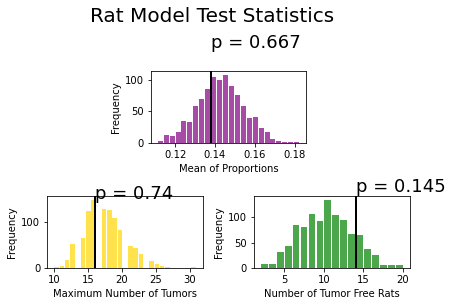

In [26]:
# (i) mean, (ii) max & (iii) # of zeros
Test_rat = np.c_[(tumor_draws / np.asarray(rat_df['rats'])[None,:]).mean(axis=1),
                 (tumor_draws).max(axis=1),
                 (tumor_draws==0).sum(axis=1) ]

obs_rat = np.array([(rat_df['tumors']/rat_df['rats']).mean(),
                    (rat_df['tumors']).max(),
                    (rat_df['tumors']==0).sum()])
rat_pvalues = [(Test_rat[:,j] >= obs_rat[j]).mean() for j in range(3)]

#Sets up grid for our three figures
ax1 = plt.subplot2grid(shape=(4,4), loc=(0,1), colspan=2,rowspan = 2)
ax2 = plt.subplot2grid((4,4), (2,0), colspan=2,rowspan = 2)
ax3 = plt.subplot2grid((4,4), (2,2), colspan=2,rowspan = 2)

ax = [ax1,ax2,ax3]
col = ['purple', 'gold','green']
test_labels = ['Mean of Proportions','Maximum Number of Tumors',
               'Number of Tumor Free Rats']

for j in range(3):
    plt.tight_layout()
    ax[j].hist(x = Test_rat[:,j],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].axvline(obs_rat[j], color='black', linewidth=2)
    ax[j].text(obs_rat[j], 150,'p = ' + str(rat_pvalues[j]), fontsize = 18)
    ax[j].set_ylabel("Frequency")
    ax[j].set_xlabel(test_labels[j])
plt.suptitle('Rat Model Test Statistics', y = 1.05,fontsize=20)

### Problem 9: BDA 3rd Ed. Exercise 7.6

Fitting a power-transformed normal model: Table 7.3 gives short-term radon measurements for a sample of houses in three counties in Minnesota (see Section 9.4 for more
on this example). For this problem, ignore the first-floor measurements (those indicated
with asterisks in the table).

In [3]:
### Problem 9 (BDA 3rd Ed, Exercise 7.6)
    
'''
Convenient way to store our info. Can't make this into a dataframe since not
all of lengths are equal.
'''

#county radon measurements(excludes basement measurements)
radon  = {
       'Blue Earth':np.array([5,13,7.2,6.8,12.8,9.5,6,3.8,1.8,6.9,4.7,9.5]),
       'Clay':  np.array([12.9,2.6,26.6,1.5,13,8.8,19.5,9.0,13.1,3.6]),
       'Goodhue': np.array([14.3,7.6,2.6,43.5,4.9,3.5,4.8,5.6,3.5,3.9,6.7])
                   } 

> (a) Fit the power-transformed normal model from Exercise 7.5(b) to the basement measurements in Blue Earth County.

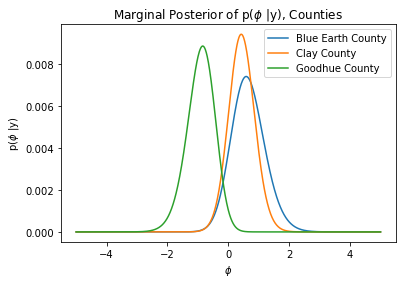

In [4]:
#PART A
N9 = 1000
phi = np.linspace(start = -5, stop = 5 , num = N9)

phi_prior = lambda x: 1
#with our drawa od blue earth, we will update our values of phi
def phi_post(y,phi,prior):
    '''
    PARAMETERS:
    ----------
        y-data
        phi - phi parameter
        prior - prior for phi
    Returns:
    -------
        logpost: natural logarithm of unnormalized posterior density
    '''
    n = len(y) #shorthand
    log_boxcox_var = ((n-1)/2)*np.log( boxcox(y,phi).var(ddof=1,axis=0) )
    logprior = np.log(prior(phi)) + (phi-1)*(1-(1/n))*( np.log(y) ).sum()
    logpost = logprior - log_boxcox_var #log posterior
    return logpost

#this becomes a dataframe that contains all of the posteriors for phi
radon_post = {
        'Blue Earth': phi_post(y = radon["Blue Earth"][:,None], phi = phi,
                               prior = phi_prior),
        'Clay':phi_post(y = radon["Clay"][:,None], phi = phi,
                        prior = phi_prior),
        'Goodhue': phi_post(y = radon["Goodhue"][:,None], phi = phi,
                            prior = phi_prior)}

radon_post = pd.DataFrame(radon_post)

#normalize the columns
radon_post = radon_post.apply(lambda x: np.exp(x)/np.sum(np.exp(x)))

#This is what our plot of p(phi|y) should look like
[plt.plot(phi,radon_post[x]) for x in radon_post.columns]
plt.title("Marginal Posterior of "+r'p($\phi$ |y)'+", Counties")
plt.xlabel(r'$\phi$')
plt.ylabel(r'p($\phi$ |y)')
plt.legend(["Blue Earth County","Clay County","Goodhue County"])
plt.show()

In [5]:
#now based on the vector, we draw most likely values of phi
BE_samples = np.random.choice(phi, size=len(phi), replace=True, 
                              p = radon_post['Blue Earth'])

#add jitter
d_phi = np.diff(phi)[0]/2

#Posterior Draws
BE_samples += -d_phi + d_phi*rand(len(phi))

#Posterior draws for mu, sigma
def norm_draws(y,phi):
    '''
    PARAMETERS:
    ----------
        y - data 
        phi - posterior draws from phi | y
    Returns:
    -------
        tuple of (mu,sigma) draws the same length of phi
    '''
    n =  len(y) #individual data lengths
    boxcox_samples = boxcox(y[:,None],phi)
    
    sample_mean = boxcox_samples.mean(axis=0)
    sample_var = boxcox_samples.var(ddof=1,axis=0)
    sigma = np.sqrt((n-1)*sample_var / chi2.rvs(df = n - 1, size = len(phi)) )
    mu = norm.rvs(loc = sample_mean,scale = sigma/np.sqrt(n),size = len(phi))
    return mu, sigma

#statistics for part a model
BE_data = {
        'Phi': BE_samples,
        'Blue Earth mu': norm_draws(radon["Blue Earth"], phi = BE_samples)[0],
        'Blue Earth sigma': norm_draws(radon["Blue Earth"], phi = BE_samples)[1],
        }

BE_data = pd.DataFrame(BE_data)

param_stats(X = BE_data,
            p = [0.025,0.25,0.50,0.75,0.975], 
            names = ["Phi","Blue Earth mu","Blue Earth sigma"], sig = 2)

,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
Phi,0.67,0.55,-0.38,0.30,0.66,1.04,1.73
Blue Earth mu,5.75,6.39,1.28,2.48,3.84,6.75,19.65
Blue Earth sigma,3.70,6.07,0.31,0.94,1.88,4.06,17.68


(b) Fit the power-transformed normal model to the basement measurements in all three
counties, holding the parameter $\phi$ equal for all three counties but allowing the mean
and variance of the normal distribution to vary

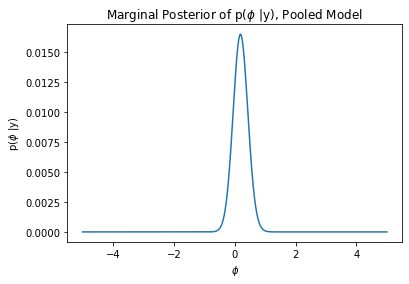

In [6]:
#PART B

def pooled_phi_post(y,phi,prior):
    '''
    PARAMETERS:
    ----------
        y-data (NOTE: data is in dictionary form)
        phi - phi parameter
        prior - prior for phi
    Returns:
    -------
        logpost: natural logarithm of unnormalized posterior density
    '''
    y_pooled = np.concatenate([y[x] for x in y.keys()],)
    N = len(y_pooled) #shorthand for pooled length
    n =  np.array([len(y[x]) for x in y.keys()]) #individual data lengths
    
    log_geo_mean = (phi-1)*(1-(1/N))*np.sum( np.log(y_pooled) ) #log geometric mean
    
    #does boxcox transform for each set, and takes the variance
    boxcox_y = np.array([boxcox(y[x][:,None],phi).var(ddof=1,axis=0) 
                         for x in y.keys()] )
    
    #finishes calculation of the denominator seen in solutions
    log_boxcox_var = np.array([((n[x]-1)/2)*np.log( boxcox_y[x,:] )
                               for x in range(len(n)) ] )
    log_boxcox_var = log_boxcox_var.sum(axis=0)
    
    logprior = np.log(prior(phi)) + log_geo_mean #log of the prior + log geometric mean
    logpost = logprior - log_boxcox_var #log posterior
    return logpost

### PART B
radon_post['Pooled'] = pooled_phi_post(y = radon, phi = phi, prior = phi_prior )
radon_post['Pooled'] = np.exp(radon_post['Pooled']) / (np.exp(radon_post['Pooled'])).sum()

#This is what our plot of p(phi|y) should look like
plt.plot(phi,radon_post['Pooled'])
plt.title("Marginal Posterior of "+r'p($\phi$ |y)'+", Pooled Model")
plt.xlabel(r'$\phi$')
plt.ylabel(r'p($\phi$ |y)')
plt.show()

In [7]:
#now based on the vector, we draw most likely values of phi
pooled_phi = np.random.choice(phi, size=len(phi), 
                                      replace=True, p = radon_post['Pooled'])
pooled_phi += -d_phi + d_phi*rand(len(phi))

#statistics for part b model

county_stats = {
        'Phi': pooled_phi,
        'Blue Earth mu': norm_draws(radon["Blue Earth"], phi = pooled_phi)[0],
        'Blue Earth sigma': norm_draws(radon["Blue Earth"], phi = pooled_phi)[1],
        'Clay mu': norm_draws(radon["Clay"], phi = pooled_phi)[0],
        'Clay sigma': norm_draws(radon["Clay"], phi = pooled_phi)[1],
        'Goodhue mu': norm_draws(radon["Goodhue"], phi = pooled_phi)[0],
        'Goodhue sigma': norm_draws(radon["Goodhue"], phi = pooled_phi)[1]
        }

county_stats = pd.DataFrame(county_stats)

param_stats(X = county_stats,
            p = [0.025,0.25,0.50,0.75,0.975], 
            names = ["Phi","Blue Earth mu","Blue Earth sigma",
                     "Clay mu","Clay sigma","Goodhue mu","Goodhue sigma"], sig = 2)

,Mean,Standard Deviation,2.5%,25.0%,50.0%,75.0%,97.5%
Phi,0.19,0.24,-0.25,0.02,0.19,0.35,0.68
Blue Earth mu,2.39,0.75,1.39,1.87,2.24,2.76,4.18
Blue Earth sigma,0.91,0.48,0.36,0.58,0.79,1.11,2.13
Clay mu,2.95,1.31,1.37,2.10,2.65,3.43,6.27
Clay sigma,1.68,1.07,0.56,0.99,1.40,2.03,4.54
Goodhue mu,2.45,1.07,1.27,1.79,2.21,2.79,5.09
Goodhue sigma,1.73,1.53,0.44,0.87,1.33,2.02,5.53


> (c)  Check the fit of the model using posterior predictive simulations.

In [8]:
#PART C: Posterior Predictive Simulations

def boxcox_samples(n,y,phi):
  '''
  PARAMETERS:
  ----------
    n - number of samples
    y - data
    phi - posterior draw of phi
  Returns:
  -------
   matrix of replications of original data ( n by length of data)
  '''
  
  #draw samples
  #First, create your boxcox data
  boxcox_data =  boxcox(y,phi)
  
  #Second,now get sufficient statistics for the data
  y_mean, y_var = boxcox_data.mean(), boxcox_data.var(ddof=1)
  N = len(y)
  
  #get our samples of mu, sigma
  sigma = np.sqrt((N-1)*y_var / chi2.rvs(df = N - 1, size = n) )
  mu = norm.rvs(loc = y_mean,scale = sigma/np.sqrt(N),size = n)
  
  #use samples of mu, sigma to get boxcox draws
  data = norm.rvs(loc = mu[:,None],scale = sigma[:,None],size = (n,N))
  #reverse samples
  invdata = inv_boxcox(data,phi) 
  return invdata

#mode of p(phi|y)
pooled_mode = phi[radon_post['Pooled'].argmax()]

#Replications
BlueEarth_reps = boxcox_samples(n=1000,y=radon["Blue Earth"],phi=pooled_mode)
np.sum( np.isnan(BlueEarth_reps) )

Clay_reps = boxcox_samples(n=1000,y=radon["Clay"],phi=pooled_mode)
np.sum(np.isnan(Clay_reps) )

Goodhue_reps = boxcox_samples(n=1000,y=radon["Goodhue"],phi=pooled_mode)
np.sum(np.isnan(Goodhue_reps) )

1

Maximum Test Statistic

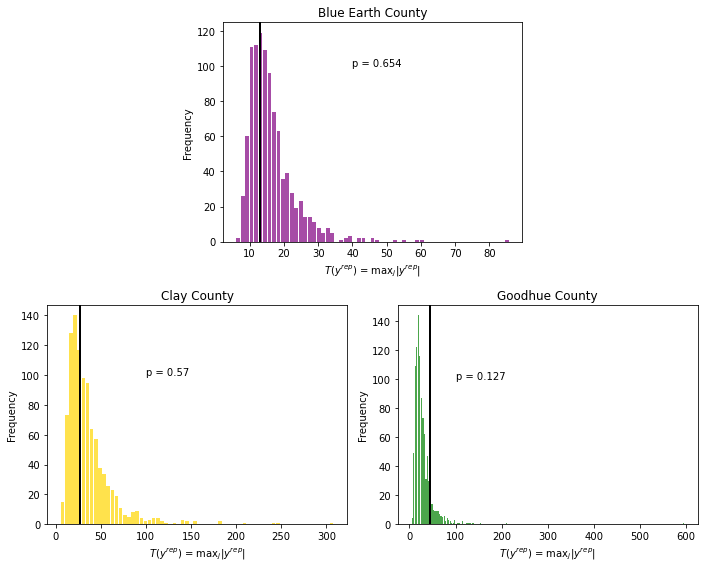

In [11]:
### TEST STATISTICS

#(i) Maximum
max_rep = np.c_[BlueEarth_reps.max(axis=1),Clay_reps.max(axis=1),Goodhue_reps.max(axis=1)]
max_obs = np.array([radon['Blue Earth'].max(),radon['Clay'].max(),radon['Goodhue'].max()])

#places to put the p value text on histograms. Adjustable
x_max = np.array([40,100,100])
y_max = np.array([100,100,100])

fig = plt.subplots(figsize=(10,8))

#Sets up grid for our three figures
ax1 = plt.subplot2grid(shape=(4,4), loc=(0,1), colspan=2,rowspan = 2)
ax2 = plt.subplot2grid((4,4), (2,0), colspan=2,rowspan = 2)
ax3 = plt.subplot2grid((4,4), (2,2), colspan=2,rowspan = 2)

ax = [ax1,ax2,ax3]
col = ['purple','gold','green']
county_labels = ['Blue Earth County','Clay County','Goodhue County']

for j in range(3):
    plt.tight_layout()
    ax[j].hist(x = max_rep[:,j],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].axvline(max_obs[j], color='black', linewidth=2)
    ax[j].text(x_max[j],y_max[j],'p = ' + str( (max_rep[:,j] >= max_obs[j]).mean() ))
    ax[j].set_ylabel("Frequency")
    ax[j].set_xlabel(r'$T(y^{rep})$ = 'r'$\operatorname{max}_{j} |y^{rep}|$')
    ax[j].set_title(county_labels[j])

Standard Deviation Test Statistic

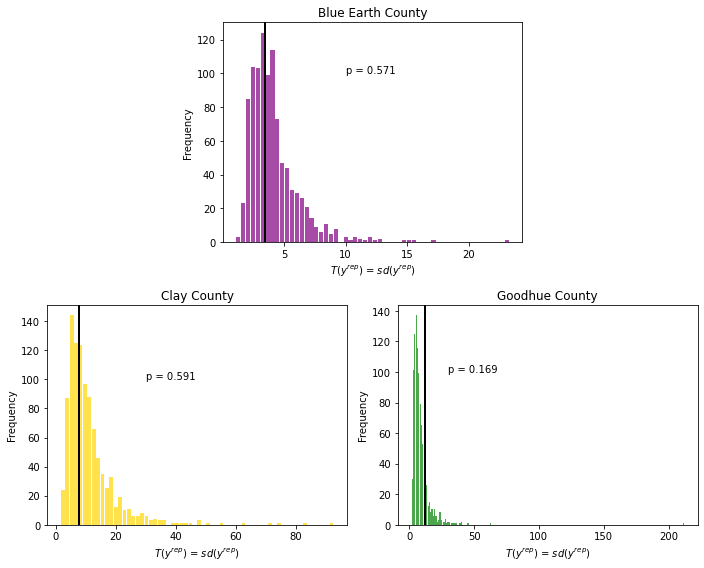

In [10]:
#(ii) Standard Deviation
sd_rep = np.c_[BlueEarth_reps.std(axis=1,ddof=1),
               Clay_reps.std(axis=1,ddof=1),
               Goodhue_reps.std(axis=1,ddof=1)]
sd_obs = np.array([radon['Blue Earth'].std(ddof=1),
                   radon['Clay'].std(ddof=1),
                   radon['Goodhue'].std(ddof=1)])

#places to put the p value text on histograms. Adjustable
x_sd = np.array([10,30,30])
y_sd = np.array([100,100,100])

fig = plt.subplots(figsize=(10,8))

#Sets up grid for our three figures
ax1 = plt.subplot2grid(shape=(4,4), loc=(0,1), colspan=2,rowspan = 2)
ax2 = plt.subplot2grid((4,4), (2,0), colspan=2,rowspan = 2)
ax3 = plt.subplot2grid((4,4), (2,2), colspan=2,rowspan = 2)

ax = [ax1,ax2,ax3]
col = ['purple','gold','green']
county_labels = ['Blue Earth County','Clay County','Goodhue County']

for j in range(3):
    plt.tight_layout()
    ax[j].hist(x = sd_rep[:,j],bins='auto', color=col[j], alpha=0.7, rwidth=0.85)
    ax[j].axvline(sd_obs[j], color='black', linewidth=2)
    ax[j].text(x_sd[j],y_sd[j],'p = ' + str( (sd_rep[:,j] >= sd_obs[j]).mean() ))
    ax[j].set_ylabel("Frequency")
    ax[j].set_xlabel(r'$T(y^{rep})$ = 'r'$sd(y^{rep})$')
    ax[j].set_title(county_labels[j])